In [ ]:
!pip install -Uq diffusers transformers fastcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.0 MB/s eta 0:00:00


In [ ]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# The Diffusion Pipeline

The Diffusers library uses `StableDiffusionPipeline`, which is an end-to-end diffusion inference pipeline to combine all the steps in the diffusion process to easily do inference with the model.

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Looking inside the pipeline

The diffusion pipeline combines all the components of stable diffusion for convenient inference. Let's build the pipeline back by putting together its components.

The main componets of a latent diffusion algorithm are:

1. An autoencoder (VAE)- for compressing the image in the latent space
2. A u-net- for predicting noise in the latent image
3. A text encoder: for creating embeddings of text and images.  

The output of a u-net, the noise residual, is used for gradual denoising of the latent image representation via a scheduler algorithm.

In [ ]:
del pipe

First, we need a text tokenizer and text encoder. Stable Diffusion uses the CLIP encoder by Open AI, so we'll be using its weights:

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Next, we'll use the `vae` and `unet` models.

In [ ]:
from diffusers import AutoencoderKL, UNet2DConditionModel

In [ ]:
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

The standard pipeline used the PNDM scheduler, but we'll use the K-LMS scheduler.
We need to use the same noising schedule as was used during training. The schedule is defined by the time step at which the noise is added and the amount of noise that is added, which is given by the beta parameters.
For the K-LMS scheduler, this is how the betas evolve:

Text(0, 0.5, 'β')

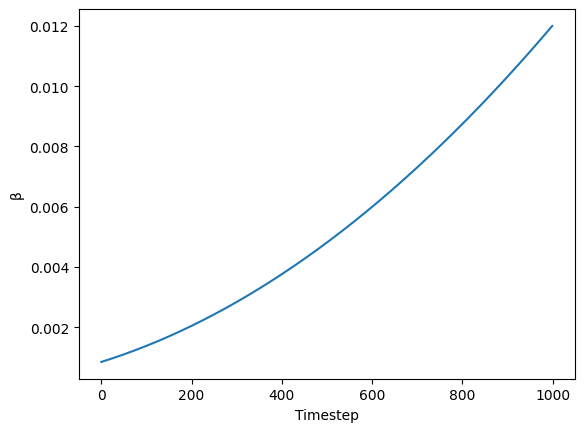

In [ ]:
beta_start, beta_end = 0.00085, 0.012
plt.plot(torch.linspace(beta_start ** 0.5, beta_end ** 0.5, 1000) ** 2)
plt.xlabel('Timestep')
plt.ylabel('β')

In [ ]:
from diffusers import LMSDiscreteScheduler

In [ ]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule='scaled_linear', num_train_timesteps=1000)

We'll now define the parameters we'll use for generation

In [ ]:
prompt = "Batman drinking coffee while sitting in a cafe"

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

Next, we tokenize the prompt. To ensure that we have same number of tokens for each prompt, we'll use max length padding and truncation.

In [ ]:
text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
text_input['input_ids']

tensor([[49406,  7223,  5778,  2453,  1519,  4919,   530,   320,  4979, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

In [ ]:
tokenizer.decode(49407), tokenizer.decode(49406)

('<|endoftext|>', '<|startoftext|>')

In [ ]:
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

The text encoder gives us the embeddings for the text prompt we have used.

In [ ]:
text_embeddings = text_encoder(text_input.input_ids.to('cuda'))[0].half()
text_embeddings.shape

torch.Size([1, 77, 768])

We'll also get the embeddings required for unconditional generation, which is achieved with an empty string; the model is free to go anywhere as long as the results as reasonable. These embeddings will be used for classifier-free guidance.

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(['']*batch_size, padding='max_length',max_length=max_length, return_tensors='pt')
uncond_embeddings = text_encoder(uncond_input.input_ids.to('cuda'))[0].half()
uncond_embeddings.shape

torch.Size([1, 77, 768])

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([text_embeddings, uncond_embeddings])
text_embeddings.shape

torch.Size([2, 77, 768])

To start the denoising process, we'll start from pure Gaussian noise. These are our initial latents.

In [ ]:
torch.manual_seed(42)
latents = torch.randn((batch_size, unet.in_channels, height//8, width//8))
latents = latents.to('cuda').half()
latents.shape

<ipython-input-20-fdfe568ba702>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height//8, width//8))


torch.Size([1, 4, 64, 64])

We initialize the scheduler with `num_inference_steps`. This will prepare the internal state to be used during denoising.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

We scale the latents with the initial standard deviation required by the scheduler.

In [ ]:
latents = latents * scheduler.init_noise_sigma

We are now ready to write the denoising loop. The timesteps go from `999` to `0` following a given schedule.

In [ ]:
scheduler.timesteps

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3044, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9131, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0869, 260.6087, 246.1304, 231.6522, 217.1739, 202.6956,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3044, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000])

In [ ]:
scheduler.sigmas

tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7477,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

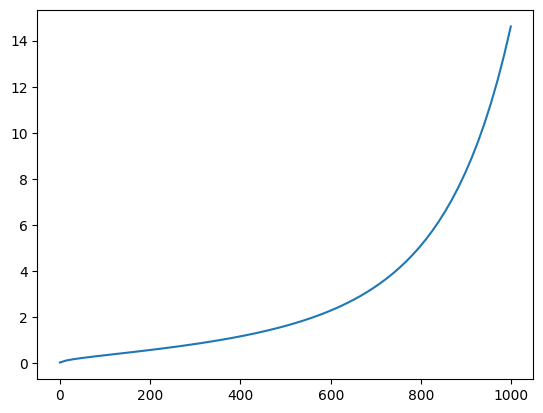

In [ ]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])

In [ ]:
from tqdm.auto import tqdm

In [ ]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents]*2)
    input = scheduler.scale_model_input(input, t)

    #predict the noise residual
    with torch.no_grad():
        pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

    #perform guidance
    pred_text, pred_uncond = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    #compute the previous 'noisy' sample
    latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

Now, our latents contain the denoised representation of the image. We use the `vae` decoder to convert it back to the pixel-space.

In [ ]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

And finally, lets convert it back to `PIL` to display the image.

The arithmetic acrobats are done to convert the decoded image in a form that can be used correctly by the `PIL`.

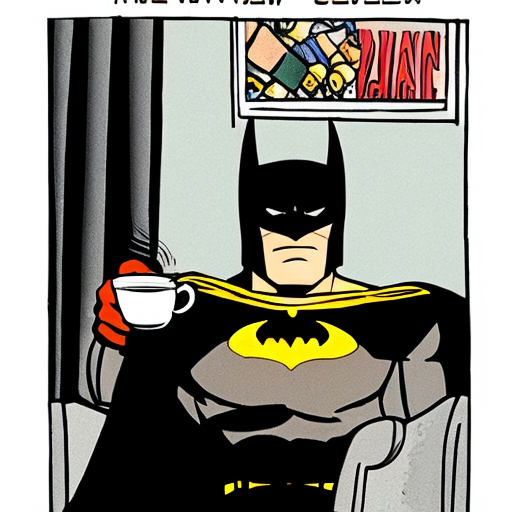

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

Voila! Here's our Batman with his coffee.

This was the text2image pipeline. Now, let's build the img2img pipeline. Instead of starting with pure noise, we'll start with a certain image and add noise to it. We skip the initial steps of the denoising process and pretend that the given image is what the algorithm came up with.

In [ ]:
!curl --output dog.jpg 'https://puppytoob.com/wp-content/uploads/2013/04/Dogs_In_Wind_8.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25821  100 25821    0     0   175k      0 --:--:-- --:--:-- --:--:--  175k


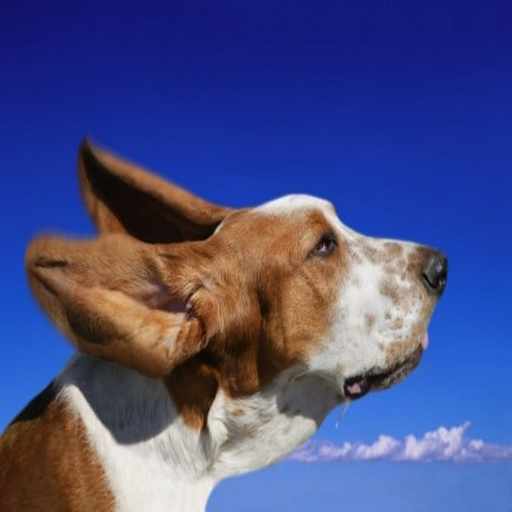

In [ ]:
input_image = Image.open('dog.jpg').resize((512, 512))
input_image

Let's create a function to encode our image into the latent space using `vae`.

In [ ]:
from torchvision import transforms as tfms

In [ ]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to('cuda').half()*2 - 1)
    return 0.18215 * latent.latent_dist.sample()

... and a function to get the image back from latent representation

In [ ]:
def latents_to_pil(latents):
    # batch of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [ ]:
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

Now, let's repeat the process we did above, except that we will start with the input image and not with pure noise.

  0%|          | 0/70 [00:00<?, ?it/s]

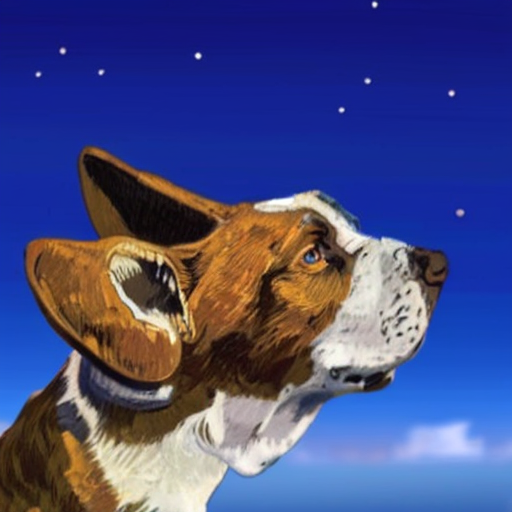

In [ ]:
#set parameters
prompt = ['A photo in the style of Vincent Van Gogh']
height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

# Prep text embeddings
text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
text_embeddings = text_encoder(text_input.input_ids.to('cuda'))[0].half()
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""]*batch_size, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
uncond_embeddings = text_encoder(uncond_input.input_ids.to('cuda'))[0].half()
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#Prep scheduler (set num of inference steps)
scheduler.set_timesteps(num_inference_steps)

#Prep latents
start_step = 30
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to('cuda').half()

#Denoising loop
for i, t in enumerate(tqdm(scheduler.timesteps)):
    if i > start_step:
        input = torch.concat([latents]*2)
        input = scheduler.scale_model_input(input, t)

        #predict noise residual
        with torch.no_grad():
            pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

        #perform guidance
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        #compute prev noisy sample
        latents = scheduler.step(pred, t, latents).prev_sample

latents_to_pil(latents)[0]